(sec_guide_smc)=
# Inferring parameters

This page shows how to infer parameters with Sequential Monte Carlo (SMC).
* We'll continue to use the two-parameter
  bottleneck model from the [](sec_guide_creating_a_dinf_model) page.
* We'll plot the results with the `dinf-plot` command.

The results below were obtained in under 10 minutes using an 8 core laptop without a GPU.


## SMC

Using the `dinf smc` subcommand, we'll do 20 iterations of Monte Carlo simulations,
with 1000 training replicates and 1000 proposal replicates in each iteration.
In each iteration this will
* train the discriminator on 500 samples from the generator
  (with parameter values sampled from the sampling
  distribution) and 500 samples from the target dataset
  (using the `truth` parameter values, as this is a simulation-only model),
* sample 1000 proposals from the generator (with parameter values taken from
  the sampling distribution),
* apply the discriminator on the proposals to obtain likelihood values,
* construct a posterior distribution from the proposals using a weighted
  kernel density estimate, where the weights are given by the likelihoods,
* set the sampling distribution for the next iteration to the posterior
  that was just constructed.

We'll also evaluate the discriminator on 1000 test replicates
(500 from each of the prior distribution and the target dataset).
This test dataset is constructed only once, not in each iteration like
the training or proposal datasets.

In [ ]:
%%bash
mkdir -p out/bottleneck-smc
rm -fr out/bottleneck-smc
time dinf smc \
    --seed 1234 \
    --epochs 5 \
    --iterations 20 \
    --training-replicates 1000 \
    --test-replicates 1000 \
    --proposal-replicates 1000 \
    --model ../../examples/bottleneck/model.py \
    --output-folder out/bottleneck-smc

## Plotting results

In [ ]:
%%bash
dinf-plot gan \
    --model ../../examples/bottleneck/model.py \
    --output-file /tmp/bottleneck-smc.svg \
    out/bottleneck-smc

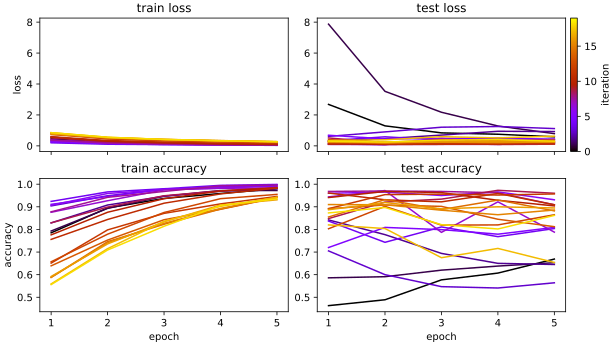

In [2]:
from IPython.display import SVG, display

display(SVG(filename="/tmp/bottleneck-smc_metrics.svg"))

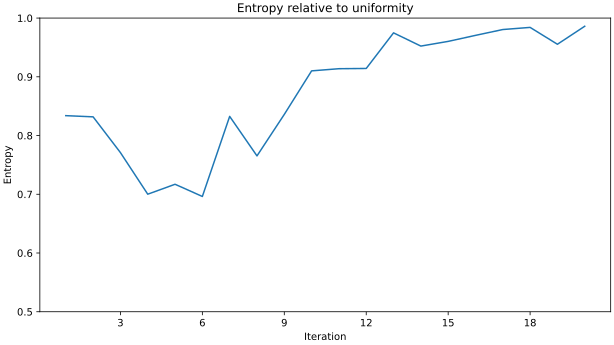

In [3]:
from IPython.display import SVG, display

display(SVG(filename="/tmp/bottleneck-smc_entropy.svg"))

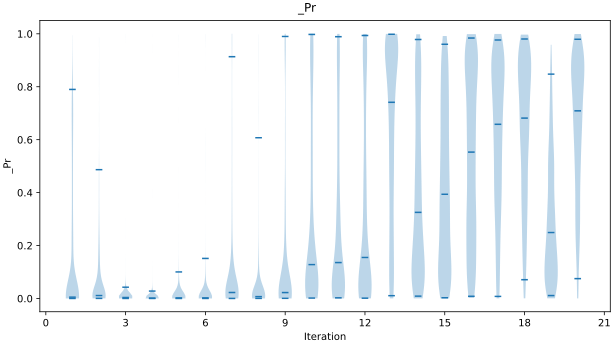

In [4]:
from IPython.display import SVG, display

display(SVG(filename="/tmp/bottleneck-smc__Pr.svg"))

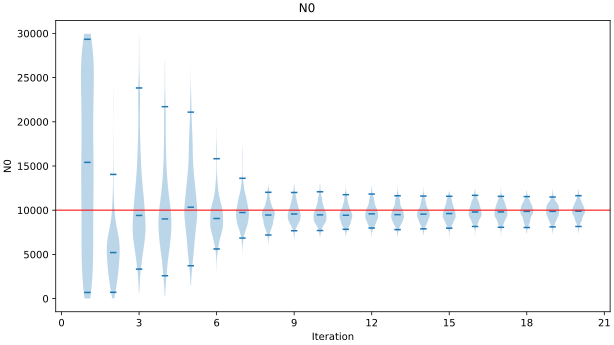

In [5]:
from IPython.display import SVG, display

display(SVG(filename="/tmp/bottleneck-smc_N0.svg"))

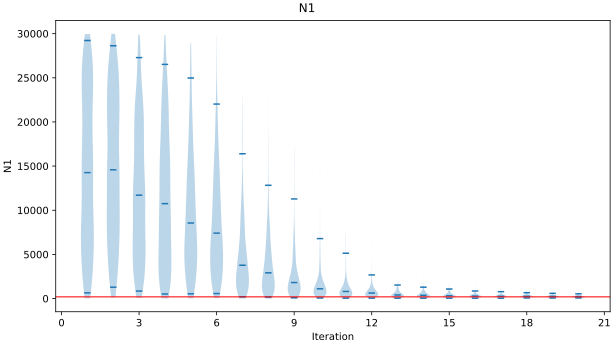

In [6]:
from IPython.display import SVG, display

display(SVG(filename="/tmp/bottleneck-smc_N1.svg"))

In [7]:
%%bash
dinf-plot hist \
    --weighted \
    --kde \
    --model ../../examples/bottleneck/model.py \
    --output-file /tmp/bottleneck-smc_hist.svg \
    out/bottleneck-smc/19/smc.npz

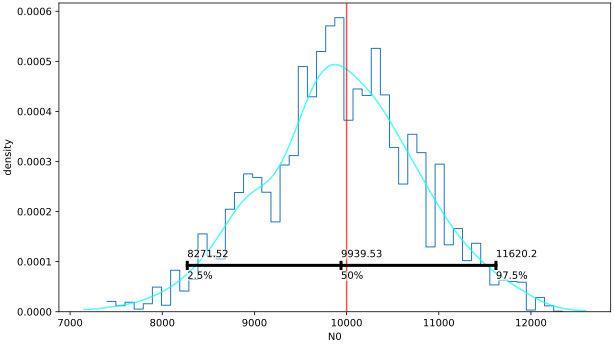

In [8]:
from IPython.display import SVG, display

display(SVG(filename="/tmp/bottleneck-smc_hist_N0.svg"))

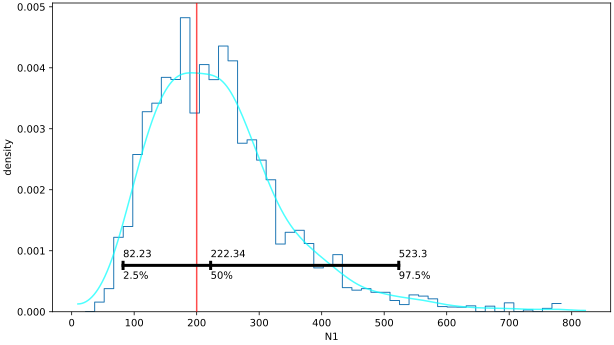

In [9]:
from IPython.display import SVG, display

display(SVG(filename="/tmp/bottleneck-smc_hist_N1.svg"))

In [10]:
%%bash
dinf-plot hist2d \
    --weighted \
    --model ../../examples/bottleneck/model.py \
    --output-file /tmp/bottleneck-smc_hist2d.svg \
    out/bottleneck-smc/19/smc.npz

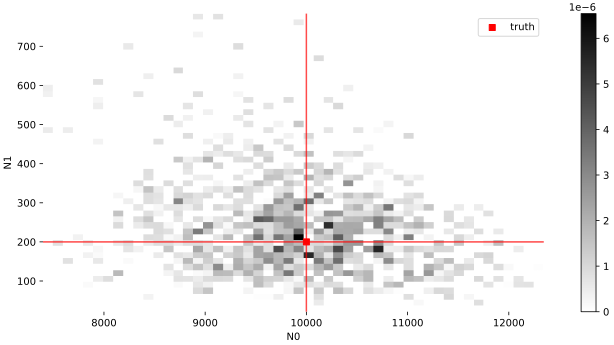

In [11]:
from IPython.display import SVG, display

display(SVG(filename="/tmp/bottleneck-smc_hist2d.svg"))

## Tabulating the results
The `dinf-tabulate` command has a
`quantiles` subcommand that outputs data quantiles.
The default behaviour is to calculate the 0.025, 0.5, 0.975 quantiles,
and print them as tab-separated values.

In [12]:
%%bash
dinf-tabulate quantiles \
    --weighted \
    out/bottleneck-smc/19/smc.npz

Param	0.025	0.5	0.975
N0	8271.517849092927	9939.527731193346	11620.19949172832
N1	82.2339446503897	222.3362344216462	523.3045728042372
